# Team-level Pass Sonars for the FIFA WWC 2019

## Motivation
I have been tweeting these pass sonars recently and had enough people ask me about code/methodology and hence this notebook.  

### What even is a pass sonar and why should I care?

Pass sonars are these neat visualizations which I first saw from [Eliot McKinley](https://twitter.com/etmckinley). I'm not sure if he's the one who first came up with this and he doesn't take credit but for me he is, so well, I call them Eliot's sonars. Anyway, the sonars themselves are just bar plots on a polar axes. As with bar charts, the height of the bars shows some value $a$. While colors are usually meaningless in bar charts on the conventional cartesian axes, they come together to look really neat on a polar axes (along with representing some value, say, $b$).

I like $a$ to be the **frequency** and $b$ to be the **average length** of the passes in certain direction (again, this is the ASA way, not my original idea). So north is the opponent's goal, Ssouth is your own goal and the directions and counts in the sonars should be interpreted that way. 

## Code

In [1]:
import json
import pandas as pd
from pandas import json_normalize
import numpy as np

import requests
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale

from matplotlib import cm
import matplotlib.pyplot as plt

There are quite a few Statsbomb APIs, dataloaders, convenience functions etc. (check [here](https://github.com/statsbomb/statsbombpy), [here](https://github.com/Torvaney/statsbombapi), [here](https://github.com/imrankhan17/statsbomb-parser)) people have put together for the Statsbomb data. We don't really need any of those for such a simple task so I'll just load in the data writing our own functions as the Lord intended. 

In [2]:
def get_match_ids(competition_id=72, season_id=30):
    """Get the match ids for a certain season or certain tournament. Default competition and season values are for the FIFA WWC 2019.
    Returns:
        list of all match_ids
    """
    
    match_ids_dict = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/{competition_id}/{season_id}.json").json()
    return [match["match_id"] for match in match_ids_dict]

`get_match_ids` will give us our list of match_ids. The next bit is to loop over the match_ids and pull all the data into a single `dataframe`. Why do we need to do that? So that we can loop over all the teams and then plot their sonars later on.

***Note***: 
1. *I'm fairly certain using the remote data you've git cloned is faster than making http requests 52 times (which is the total number of matches in the FIFA WWC 2019 dataset) but I'm assuming everyone hasn't.*
2. *Also, pulling everything into a single dataframe is not ideal but definitely faster than opening and closing files/making requests for every team 52 times. (Ideally, I guess, you'd probably want to create a relational database out of all events first)*

In [3]:
def get_all_passes(match_ids_list):
    """Gives all passes of a list of matches concatenated in a dataframe
    Args:
        match_ids_list: list of match_ids
    Returns:
        dataframe of all passes 
    """
    dflist = []
    for match_id in tqdm(match_ids_list, desc = "Loading matches"):
        data = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json").json()
        dflist.append(json_normalize(data, sep="_"))
    _df = pd.concat(dflist, ignore_index=True)
    return _df.loc[(_df.type_name == 'Pass')].dropna(how="all", axis=1)

`get_all_passes` gets us all passes. Now we just need to define a function to plot polar bar plots and then loop over the teams and plot them. 

In [4]:
def pass_sonar(team_name, ax):
    """Plots the sonar for a team on a matplotlib axes
    """

##some data wrangling
    pdf = df.loc[df.team_name == team_name] ##filter only passes for the team in question
    df1 = pdf.loc[:, ["pass_length", "pass_angle"]] ##just take in lengths and angles of passes
    bins = np.linspace(-np.pi, np.pi, 24) ##change 24 to something else if you want more/less bins
    df1['bins'] = pd.cut(df1['pass_angle'], bins, include_lowest=True, right = True)
    df1["bin_mids"] = df1["bins"].apply(lambda x: x.mid)
    A = df1.groupby(["bin_mids"]).agg(frequency=("pass_length", "size"), alength = ("pass_length", "mean")).reset_index()
    A["freq"] = minmax_scale(A.frequency) ##scale to [0,1]

##plot sonar    
    bars = ax.bar(A["bin_mids"], A["freq"], width=0.27, bottom=0.01) 
    cm_ = cmap(norm(np.array(A["alength"]))) ##get our color values from the lengths for the bars
    
    ##set color
    [bar.set(facecolor=r, edgecolor="white", linewidth=.5) for r, bar in zip(cm_, bars)]
    
##Some axes cosmetics
    ax.set(rlim = [0,1], theta_zero_location = "N") ##orient upwards
    ax.title.set(text=team_name[:-8], color="k", fontweight="bold", size=7)
    ax.set_axis_off()


Everything's set. All we gotta do is run everything. Then we get our `figure` and `axes` instances. There were a total of 24 teams and hence, we'll create 24 axes (4x6). Lastly we just need to loop over the axes and team_names and plot them sequentially. 

In [5]:
##Call our functions
match_ids = get_match_ids()
df = get_all_passes(match_ids)

Loading matches: 100%|██████████| 52/52 [01:59<00:00,  2.29s/it]


<ipython-input-6-c6e185210b71>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


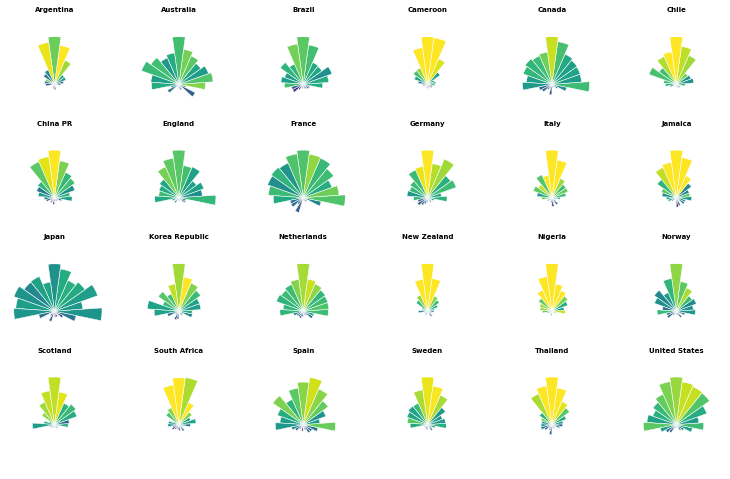

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(13,8),subplot_kw={"projection":"polar"}) 
axes = axes.flatten()
norm = plt.Normalize() ##default of (0,1) is perfect for us
cmap = cm.get_cmap("viridis")

teams = sorted(df.team_name.unique())
for team_name, ax in zip(teams, axes):
    pass_sonar(team_name, ax)

Looks acceptable so far. With knock-out tournaments there's obviously the issue of imbalanced data. Teams which keep qualifing play more matches and hence more passes and we only need to look at the sonars above to see that there's some direct relation between number of passes and sideways passing (and more fanned-out sonars). 
Also, I've made a pretty stupid mistake by not filtering out non-open-play passes. But, I'll leave it up to the reader(coder?) to fix. 